# Supervised Learning
The idea of this notebook is using different learning machines in order to see how good are timbral features to describe musical genres. 
The data used is extracted from the GTZAN dataset: mfcc using gaussian windows with 60% overlapping. The features are the mean of the mfcc and the flattened covariance matrix for a total of 250 features

In [7]:
import pandas as pd 
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from numpy import interp
from sklearn import preprocessing,manifold
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold

In [8]:
#Reading the data
data = pd.read_csv("mfccToy2.csv",header=None)
#data = pd.read_csv("mfccToyExpRock.csv",header=None)
data = pd.DataFrame(data).to_numpy()
data.shape

(300, 184)

Data preprocessing: Cleaning NaN and Normalizing without imposing a distribution

In [9]:
data = data[~np.isnan(data).any(axis=1)]
data.shape

target = data[:,-2]
X = data[:,:-2]
order = data[:,-1]
order = order.reshape(order.shape[0],1)
X_norm = (X-X.min(axis=0))/(X.max(axis=0)-X.min(axis=0))
print(data.shape,X.shape,order.shape)
X_complete = np.concatenate((X_norm, order), axis=1)

(300, 184) (300, 182) (300, 1)


In [10]:
# This function plots the 2 dimensional data with the target colors
def plotgenres(Xe,target,pred,title):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.title.set_text('Real')
    ax2.title.set_text('Predicted')
    ax1.scatter(Xe[target==1,0],Xe[target==1,1],c="lightcoral",label="blues")
    ax1.scatter(Xe[target==2,0],Xe[target==2,1],c="teal",label="country")
    ax1.scatter(Xe[target==3,0],Xe[target==3,1],c="darkred",label="rock")
    ax2.scatter(Xe[pred==1,0],Xe[pred==1,1],c="lightcoral",label="blues")
    ax2.scatter(Xe[pred==2,0],Xe[pred==2,1],c="teal",label="country")
    ax2.scatter(Xe[pred==3,0],Xe[pred==3,1],c="darkred",label="rock")
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')
    fig.suptitle(title)
    plt.show()

In [11]:
def wrong_predictions(y_pred,y_test,check_test):
    songs = []
    for i in range(y_pred.shape[0]):
        if(y_pred[i] != y_test[i]):
            songs.append(check_test[i])

    return songs

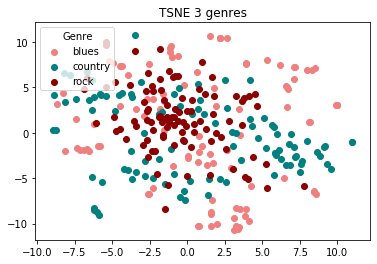

In [12]:
Xe= manifold.TSNE( metric='euclidean', method='barnes_hut').fit_transform(X_norm)
fig,ax=plt.subplots()
ax.scatter(Xe[target==1,0],Xe[target==1,1],c="lightcoral",label="blues")
ax.scatter(Xe[target==2,0],Xe[target==2,1],c="teal",label="country")
ax.scatter(Xe[target==3,0],Xe[target==3,1],c="darkred",label="rock")
plt.legend(loc='upper left',title="Genre")
plt.title('TSNE 3 genres')
plt.show()

In [13]:
# Splitting the data into train/test/validation
X_train, X_test, y_train, y_test = train_test_split(X_complete, target, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

check_test = X_test[:,-1]
X_train,X_test,X_val = X_train[:,:-1],X_test[:,:-1],X_val[:,:-1]

In [14]:
# Applying the dimensionality reduction via Barnes-Hut tsne
Xe_test= manifold.TSNE( metric='euclidean', method='barnes_hut').fit_transform(X_test)

## Classifiers

### Logistic Regression

In [15]:
logistic = LogisticRegression(max_iter = 100000)
logistic.fit(X_train,y_train)

LogisticRegression(max_iter=100000)

Precision: 0.7333333333333333
Recall: 0.7333333333333333
F1 Score: 0.7333333333333333
Error train: 8.333333333333337 %
Error test: 26.66666666666667 %
Songs that were wrong labeled: [124.0, 214.0, 107.0, 74.0, 276.0, 300.0, 59.0, 79.0, 221.0, 140.0, 249.0, 52.0, 89.0, 222.0, 1.0, 181.0]


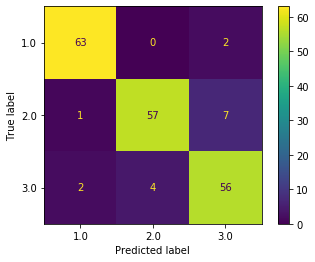

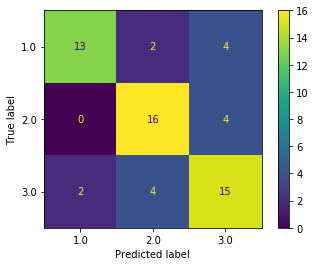

In [17]:
pred = logistic.predict(X_test)
scores = precision_recall_fscore_support(y_test, pred,average='micro')
print('Precision:',scores[0])
print('Recall:',scores[1])
print('F1 Score:',scores[2])

plot_confusion_matrix(logistic,X_train,y_train)
err = np.sum(logistic.predict(X_train) == y_train)/len(y_train)
print("Error train:",(1-err)*100,"%")

plot_confusion_matrix(logistic,X_test,y_test)
err = np.sum(logistic.predict(X_test) == y_test)/len(y_test)
print("Error test:",(1-err)*100,"%")

wrong_songs = wrong_predictions(pred,y_test,check_test)
print("Songs that were wrong labeled:",wrong_songs)

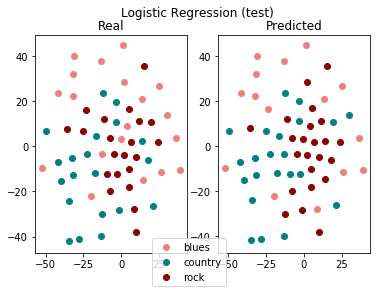

In [19]:
plotgenres(Xe_test,y_test,pred,"Logistic Regression (test)")

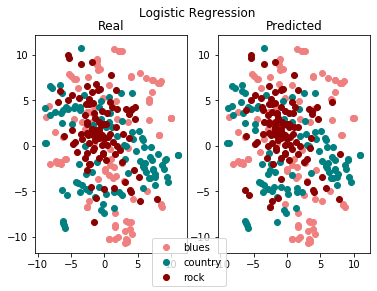

In [20]:
pred = logistic.predict(X_norm)
plotgenres(Xe,target,pred,"Logistic Regression")

## Decision Tree

In [21]:
clf = DecisionTreeClassifier(max_depth = 5)
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5)

Precision: 0.5666666666666667
Recall: 0.5666666666666667
F1 Score: 0.5666666666666667
Error train: 7.2916666666666625 %
Error test: 43.333333333333336 %


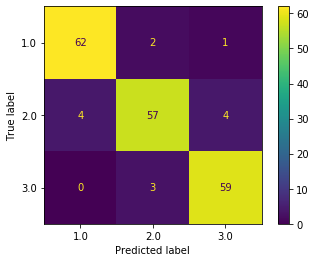

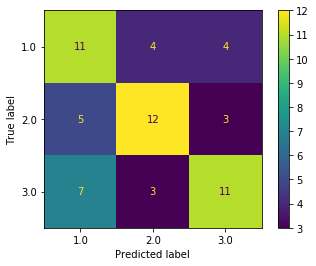

In [22]:
pred = clf.predict(X_test)
scores = precision_recall_fscore_support(y_test, pred,average='micro')
print('Precision:',scores[0])
print('Recall:',scores[1])
print('F1 Score:',scores[2])

plot_confusion_matrix(clf,X_train,y_train)
err = np.sum(clf.predict(X_train) == y_train)/len(y_train)
print("Error train:",(1-err)*100,"%")

plot_confusion_matrix(clf,X_test,y_test)
err = np.sum(clf.predict(X_test) == y_test)/len(y_test)
print("Error test:",(1-err)*100,"%")

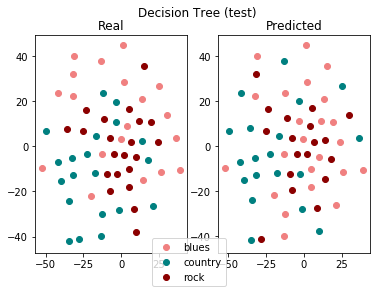

In [23]:
plotgenres(Xe_test,y_test,pred,"Decision Tree (test)")

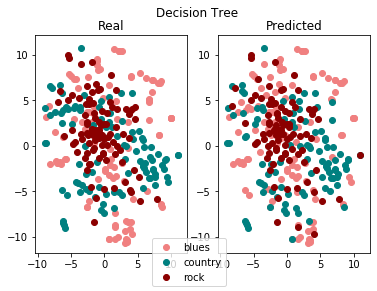

In [24]:
pred = clf.predict(X_norm)
plotgenres(Xe,target,pred,"Decision Tree")

## Support vector machine

Kernels:
* Lineal
* Polynomial
* Radial base

Precision: 0.7333333333333333
Recall: 0.7333333333333333
F1 Score: 0.7333333333333333


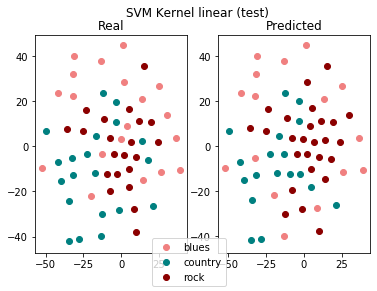

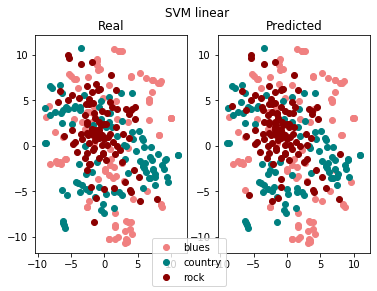

In [25]:
parameters = {'C':[0.1,0.01,1,10]}
linear_kernel_svm_clf = svm.SVC(kernel = "linear")
clf = GridSearchCV(linear_kernel_svm_clf, parameters)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
scores = precision_recall_fscore_support(y_test, pred,average='micro')
print('Precision:',scores[0])
print('Recall:',scores[1])
print('F1 Score:',scores[2])
plotgenres(Xe_test,y_test,pred,"SVM Kernel linear (test)")

pred = clf.predict(X_norm)
plotgenres(Xe,target,pred,"SVM linear")

{'C': 1}
Accuracy: 0.6066666666666667
Error train: 7.8125 %
Error test: 26.66666666666667 %
Songs that were wrong labeled: [190.0, 124.0, 214.0, 107.0, 74.0, 59.0, 79.0, 168.0, 221.0, 140.0, 52.0, 89.0, 222.0, 229.0, 1.0, 181.0]


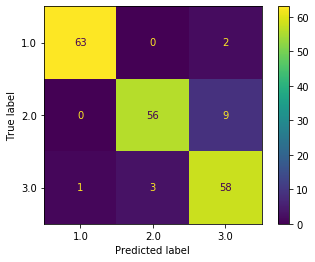

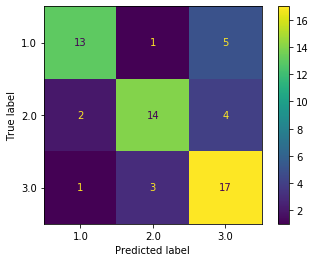

In [27]:
print(clf.best_params_)
cross_scores = cross_val_score(clf, X_norm, target, cv=10)
print("Accuracy:" ,cross_scores.mean())

plot_confusion_matrix(clf,X_train,y_train)
err = np.sum(clf.predict(X_train) == y_train)/len(y_train)
print("Error train:",(1-err)*100,"%")

plot_confusion_matrix(clf,X_test,y_test)
err = np.sum(clf.predict(X_test) == y_test)/len(y_test)
print("Error test:",(1-err)*100,"%")

pred = clf.predict(X_test)
wrong_songs = wrong_predictions(pred,y_test,check_test)
print("Songs that were wrong labeled:",wrong_songs)

Precision: 0.7
Recall: 0.7
F1 Score: 0.7


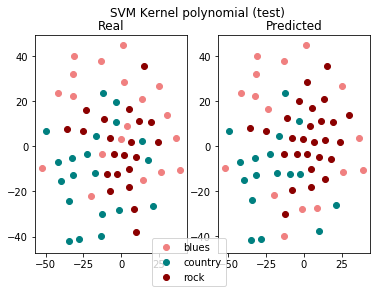

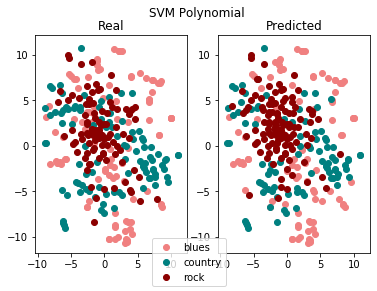

In [28]:
parameters = {'degree':[2,3,4,5,6,7,8,9,10], 'C':[0.1,0.01,1,10]}
poly_kernel_svm_clf = svm.SVC(kernel = "poly")
clf = GridSearchCV(poly_kernel_svm_clf, parameters)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
scores = precision_recall_fscore_support(y_test, pred,average='micro')
print('Precision:',scores[0])
print('Recall:',scores[1])
print('F1 Score:',scores[2])
plotgenres(Xe_test,y_test,pred,"SVM Kernel polynomial (test)")

pred = clf.predict(X_norm)
plotgenres(Xe,target,pred,"SVM Polynomial")

{'C': 0.01, 'degree': 3}
Accuracy: 0.63
Error train: 17.1875 %
Error test: 33.333333333333336 %
Songs that were wrong labeled: [124.0, 214.0, 107.0, 74.0, 276.0, 267.0, 79.0, 106.0, 19.0, 91.0, 140.0, 249.0, 52.0, 96.0, 165.0, 81.0, 222.0, 1.0, 176.0, 289.0, 215.0]


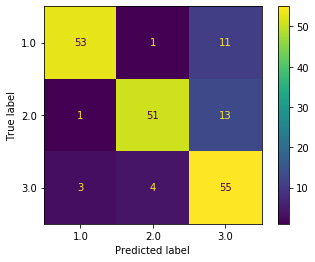

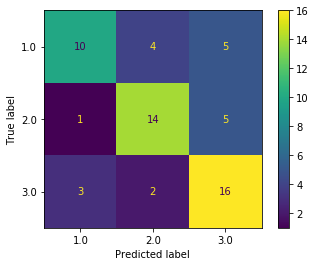

In [92]:
print(clf.best_params_)
cross_scores = cross_val_score(clf, X_norm, target, cv=10)
print("Accuracy:" ,cross_scores.mean())

plot_confusion_matrix(clf,X_train,y_train)
err = np.sum(clf.predict(X_train) == y_train)/len(y_train)
print("Error train:",(1-err)*100,"%")

plot_confusion_matrix(clf,X_test,y_test)
err = np.sum(clf.predict(X_test) == y_test)/len(y_test)
print("Error test:",(1-err)*100,"%")

pred = clf.predict(X_test)
wrong_songs = wrong_predictions(pred,y_test,check_test)
print("Songs that were wrong labeled:",bad_songs)

Precision: 0.7
Recall: 0.7
F1 Score: 0.7


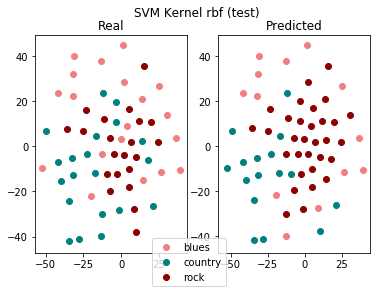

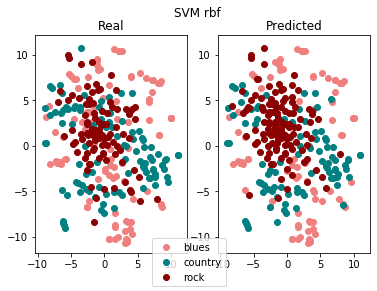

In [29]:
parameters = {'gamma':[0.001,0.01,0.1,1,10], 'C':[0.1,0.01,1,10]}
rbf_kernel_svm_clf = svm.SVC(kernel = "rbf",gamma=30,C=10)
clf = GridSearchCV(rbf_kernel_svm_clf, parameters)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
scores = precision_recall_fscore_support(y_test, pred,average='micro')
print('Precision:',scores[0])
print('Recall:',scores[1])
print('F1 Score:',scores[2])
plotgenres(Xe_test,y_test,pred,"SVM Kernel rbf (test)")

pred = clf.predict(X_norm)
plotgenres(Xe,target,pred,"SVM rbf")

{'C': 10, 'gamma': 0.01}
Accuracy: 0.6166666666666666
Error train: 15.625 %
Error test: 30.000000000000004 %
Songs that were wrong labeled: [124.0, 214.0, 107.0, 74.0, 59.0, 79.0, 168.0, 106.0, 91.0, 140.0, 52.0, 89.0, 81.0, 222.0, 1.0, 176.0, 181.0, 215.0]


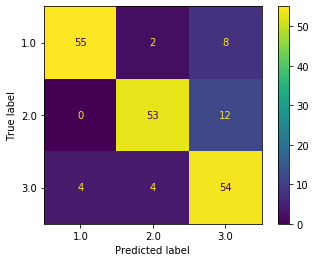

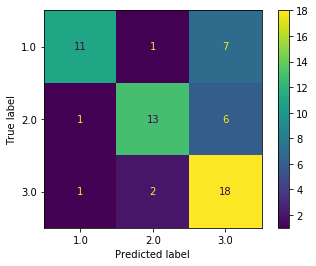

In [30]:
print(clf.best_params_)
cross_scores = cross_val_score(clf, X_norm, target, cv=10)
print("Accuracy:" ,cross_scores.mean())

plot_confusion_matrix(clf,X_train,y_train)
err = np.sum(clf.predict(X_train) == y_train)/len(y_train)
print("Error train:",(1-err)*100,"%")

plot_confusion_matrix(clf,X_test,y_test)
err = np.sum(clf.predict(X_test) == y_test)/len(y_test)
print("Error test:",(1-err)*100,"%")

pred = clf.predict(X_test)
wrong_songs = wrong_predictions(pred,y_test,check_test)
print("Songs that were wrong labeled:",wrong_songs)

## Multilayer Perceptron

* Hidden layers: $L = 1,...,3$
* Number of neurons in the hidden layers: $l_i = 1,2,3$
* Learning rate: 0.2,0.5,0.9

In [31]:
learning_rate, activation = 0.2, 'relu'
error = 0
# Choose best performance with combinations of activations and learning rate
for act in ['relu','tanh','logistic']:
    for lr in [0.002,0.005,0.009,0.008,0.0002,0.0005,0.0009,0.0008]:
        nn =  MLPClassifier(hidden_layer_sizes=(100,100,100,100,100),activation=act, learning_rate_init=lr)
        nn.fit(X_train,y_train)
        err = np.sum(nn.predict(X_val) == y_val)/len(y_val)
        print(act,lr,err)
        if(err > error):
            learning_rate, activation, error = lr,act,err
nn =  MLPClassifier(hidden_layer_sizes=(100,100,100,100,100),activation=activation, learning_rate_init=learning_rate)
nn.fit(X_train,y_train)

relu 0.002 0.6458333333333334
relu 0.005 0.6458333333333334
relu 0.009 0.4583333333333333
relu 0.008 0.6458333333333334
relu 0.0002 0.5833333333333334
relu 0.0005 0.6458333333333334
relu 0.0009 0.6041666666666666
relu 0.0008 0.6875
tanh 0.002 0.6666666666666666
tanh 0.005 0.625
tanh 0.009 0.3125
tanh 0.008 0.3333333333333333
tanh 0.0002 0.625
tanh 0.0005 0.625
tanh 0.0009 0.5833333333333334
tanh 0.0008 0.5625
logistic 0.002 0.3333333333333333
logistic 0.005 0.3125
logistic 0.009 0.5833333333333334
logistic 0.008 0.3125
logistic 0.0002 0.3333333333333333
logistic 0.0005 0.3125
logistic 0.0009 0.3125
logistic 0.0008 0.3541666666666667


MLPClassifier(hidden_layer_sizes=(100, 100, 100, 100, 100),
              learning_rate_init=0.0008)

In [32]:
pred = nn.predict(X_test)
scores = precision_recall_fscore_support(y_test, pred,average='micro')
print('Precision:',scores[0])
print('Recall:',scores[1])
print('F1 Score:',scores[2])

Precision: 0.7166666666666667
Recall: 0.7166666666666667
F1 Score: 0.7166666666666667


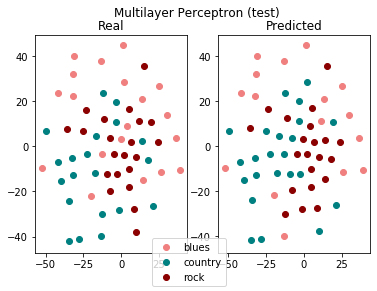

In [33]:
plotgenres(Xe_test,y_test,pred,"Multilayer Perceptron (test)")

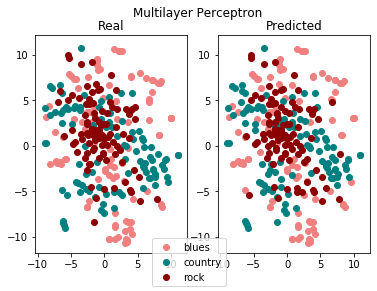

0.0034854100563607346
Error train: 15.625 %
Error test: 30.000000000000004 %
Songs that were wrong labeled: [124.0, 107.0, 74.0, 300.0, 59.0, 79.0, 168.0, 221.0, 252.0, 140.0, 249.0, 89.0, 222.0, 1.0, 285.0, 181.0, 215.0]


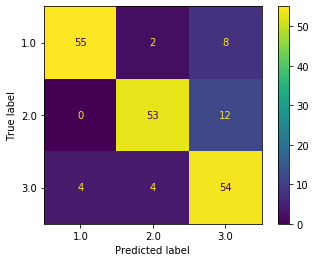

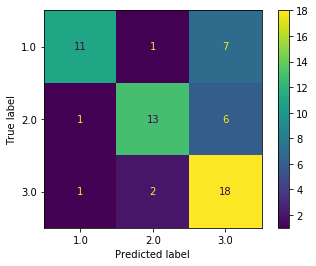

In [34]:
pred = nn.predict(X_norm)
plotgenres(Xe,target,pred,"Multilayer Perceptron")
print(nn.loss_)

plot_confusion_matrix(clf,X_train,y_train)
err = np.sum(clf.predict(X_train) == y_train)/len(y_train)
print("Error train:",(1-err)*100,"%")

plot_confusion_matrix(clf,X_test,y_test)
err = np.sum(clf.predict(X_test) == y_test)/len(y_test)
print("Error test:",(1-err)*100,"%")

pred = nn.predict(X_test)
wrong_songs = wrong_predictions(pred,y_test,check_test)
print("Songs that were wrong labeled:",wrong_songs)

| Parámetro | Logistic  Regression | Decision Tree | SVM Linear | SVM rbf | SVM Poly | Multilayer Perceptron |
|:---------:|:--------------------:|:-------------:|:----------:|:-------:|:--------:|:---------------------:|
| Precision |         0.933        |     0.883     |    0.95    |   0.6   |   0.516  |         0.933         |
|   Recall  |         0.933        |     0.883     |    0.95    |   0.6   |   0.516  |         0.933         |
|     F1    |         0.933        |     0.883     |    0.95    |   0.6   |   0.516  |         0.933         |